## Пример: House Sales in King County, USA <a name="house_case"></a>

Будем пробовать различные методы, чтобы научиться определять цену на недвижимость.  
Данные взяты с [одноименного соревнования](https://www.kaggle.com/harlfoxem/housesalesprediction) на Kaggle.  

Данные содержат информацию о продажах индивидуальных домов в период с мая 2014 года по май 2015 в округе Кинг, штат Вашингтон, США.

In [4]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
style.use('seaborn')

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

pd.set_option('display.max_columns', 25)

Matplotlib is building the font cache; this may take a moment.


In [6]:
house_data = pd.read_csv("kc_house_data.csv")

Давайте сымитируем ситуацию, когда заказчик скрыл часть данных.

In [7]:
holdout = house_data.sample(2000) # рандомная скрытая часть
house_data = house_data.loc[~house_data.index.isin(holdout.index)] #наш датасет без скрытой части

И будем дальше работать с house_data, как будто части holdout у нас никогда не было

### Комментарии по признакам

__price__ - целевая переменная (y).

__id__ - уникален для каждого объекта, необходимо удалить из выборки.

Посмотрим еще на три признака: 
* __sqft_living__ - общая площадь дома
* __sqft_above__ - общая площадь наземной части дома
* __sqft_basement__ - общая площадь подземного части дома  
  
Здравый смысл нам подсказывает, что эти признаки линейно связаны, а именно:  
$$sqft\_basement = sqft\_living - sqft\_above$$
  

In [8]:
print(house_data.sqft_basement == (house_data.sqft_living - house_data.sqft_above))

0        True
1        True
2        True
3        True
4        True
         ... 
21608    True
21609    True
21610    True
21611    True
21612    True
Length: 19613, dtype: bool


Поэтому признак sqft_basement можно удалить, оставив остальные два.

Признаки **lat** и **long** неоднозначные, но оставим их - вдруг помогут учесть географическое расположение домов. 

In [9]:
house_data[['lat', 'long']].describe()

,lat,long
count,19613.000000,19613.000000
mean,47.560015,-122.213743
std,0.138646,0.140910
min,47.155900,-122.519000
25%,47.470900,-122.328000
50%,47.572000,-122.230000
75%,47.678000,-122.125000
max,47.777600,-121.315000


### Предобработка данных

Удалим явным образом не подходящие признаки.

In [14]:
data = house_data.drop(['id', 'zipcode', 'date', 'sqft_living'], axis=1, inplace=False)

## Обучающая и тестовая выборки <a name="train_test"></a>

Для тестирования для начала применим простой метод - разделите датасет на две части: на одной будем обучать, на другой оценивать качество модели.  


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
y = data['price']
X = data.iloc[:,1:] # оставили все колонки без price

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=5) #Ваш код здесь, используйте random_state=5

NameError: name 'train_test_split' is not defined

In [18]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14709, 16) (4904, 16) (14709,) (4904,)


## K Nearest Neighbors <a name="knn"></a>

Будем обучаться на данных X_train. Нормализуйте X_train и добавьте KNeighborsRegressor с параметром n_neigbors = 5. Посчитайте чему равна MSE.

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

reg = make_pipeline (MinMaxScaler(), KNeighborsRegressor(n_neighbors = 5))
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
mae = median_absolute_error(y_test, reg.predict(X_test))

NameError: name 'X_train' is not defined

In [ ]:
print('Mean Squared Error = ',mse)
print('Median Absolute Error = ',mae)

Теперь в цикле подберите переберите параметр n_neigbors и по графику ошибок mse определите оптимальное значение

In [32]:
neighbors = range(1, 50)
errors_mse_train = []
errors_mse_test = []

for k in neighbors:
    reg = make_pipeline (MinMaxScaler(),KNeighborsRegressor(n_neighbors = k))
    reg.fit(X_train, y_train)
    
    errors_mse_train.append(mean_squared_error(y_train, reg.predict(X_train)))
    errors_mse_test.append(mean_squared_error(y_test, reg.predict(X_test)))


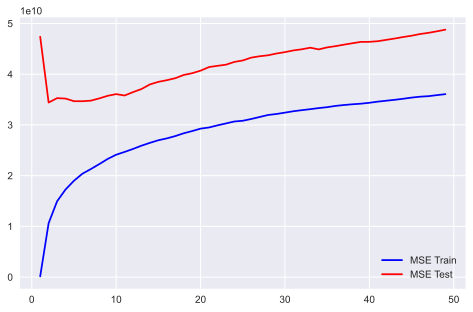

In [33]:
plt.plot(neighbors, errors_mse_train, color='blue', label='MSE Train')
plt.plot(neighbors, errors_mse_test, color='red', label='MSE Test')
plt.legend()

In [40]:
print('Оптимальное значение по MSE Test:', np.argmin(errors_mse_test))

Оптимальное значение по MSE Test: 1


Постройте такой же график, только для median_absolute_error. Совпадают ли оптимальные значения n_neigbors для 2 типов ошибок?

In [34]:
errors_mae_train = []
errors_mae_test = []

for k in neighbors:
    reg = make_pipeline (MinMaxScaler(), KNeighborsRegressor(n_neighbors = k))
    reg.fit(X_train, y_train)

    errors_mae_train.append(median_absolute_error(y_train, reg.predict(X_train)))
    errors_mae_test.append(median_absolute_error(y_test, reg.predict(X_test)))

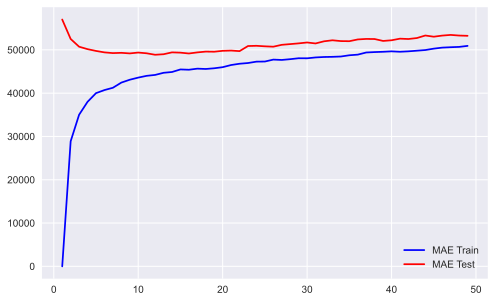

In [41]:
plt.plot(neighbors, errors_mae_train, color='blue', label='MAE Train')
plt.plot(neighbors, errors_mae_test, color='red', label='MAE Test')
plt.legend()

In [42]:
print('Оптимальное значение по MAE Test:', np.argmin(errors_mae_test))

Оптимальное значение по MAE Test: 11


## Подбор k на кросс-валидации

Теперь с помощью GridSearchCV (cv=5) переберите параметр n_neighbors еще раз и выведите best_score_ и best_params_

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kneighborsregressor__n_neighbors': range(1,50)},
]

grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train,y_train)

0.7641171244772484
{'kneighborsregressor__n_neighbors': 6}


In [53]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7641171244772484
{'kneighborsregressor__n_neighbors': 6}


Теперь посомотрим как менялась ошибка на обучающей и тестовой части по время обучения, нарисуйте на графике 2 кривые  grid_search.cv_results_['mean_train_score'] и grid_search.cv_results_['mean_test_score']

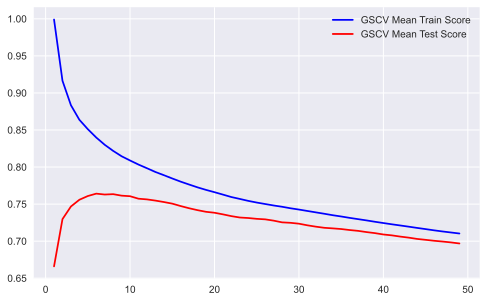

In [52]:
plt.plot(neighbors,grid_search.cv_results_['mean_train_score'] , color='blue', label='GSCV Mean Train Score')
plt.plot(neighbors,grid_search.cv_results_['mean_test_score'], color='red', label='GSCV Mean Test Score')
plt.legend()

Теперь попробуем перебрать все возможные параметры KNeighborsRegressor. Добавьте в param_grid переменные kneighborsregressor__weights,
kneighborsregressor__metric(почитайте в документации какие значения она может принимать). Выведите best_score_ и best_params_


In [59]:
param_grid = [
    {'kneighborsregressor__n_neighbors': range(1,50),
     'kneighborsregressor__weights':['uniform', 'distance'],
    'kneighborsregressor__metric':['euclidean','manhattan','chebyshev']
    }
]

grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor(n_neighbors=49))]),
             param_grid=[{'kneighborsregressor__metric': ['euclidean',
                                                          'manhattan',
                                                          'chebyshev'],
                          'kneighborsregressor__n_neighbors': range(1, 50),
                          'kneighborsregressor__weights': ['uniform',
                                                           'distance']}],
             return_train_score=True)

In [60]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7881388551716858
{'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 9, 'kneighborsregressor__weights': 'distance'}


И наконец последний этап, контрольная проверка. Вспомним что у нас была скрытая выборка holdout. Теперь c ней нужно проделать те же преобразования, что и c обучающей выборкой - удалить лишние колонки, а потом применить grid_search.best_estimator_.predict) - получим предсказанные цены на скрытой части данных. 

In [61]:
holdout = holdout.drop(['id', 'zipcode', 'date', 'sqft_living'], axis=1, inplace=False)

Остается только сравнить предсказания с истинными значениями holdout['price'] и вывести mse. 

In [68]:
y_holdout = holdout['price']
X_holdout = holdout.iloc[:,1:] 
mse_holdout = mean_squared_error(y_holdout, grid_search.best_estimator_.predict(X_holdout))

In [69]:
print('Mean Squared Error for holdout = ', mse_holdout)
print('GridSearchCV Best Score:', grid_search.best_score_)

Mean Squared Error for holdout =  20448613036.958694
GridSearchCV Best Score: 0.7881388551716858


**Разница в показателях настолько большая, потому-что kneighborsregressor использует r2_score в качестве метрики**

In [70]:
y_holdout

463      359500.0
17135    146000.0
10243    225000.0
5770     375000.0
15409    200000.0
           ...   
926      288400.0
18543    930000.0
12285    480000.0
19308    475000.0
17511    631500.0
Name: price, Length: 2000, dtype: float64

Если модель обучилась хорошо, то ошибка на holdout выборке будет примерно равна ошибка на нашей собственной тестовой части, т.е. grid_search.best_score_

## Дополнительное задание для любознательных

Повторите последний этам обучения gridsearch, в param_grid подставьте только по одному оптимальному значению из grid_search.best_params_, а вместо cv = 5 подставьте cv = LeaveOneOut(). Засеките время работы алгоритма.
Улучшился ли результат?

In [33]:
%%time
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from sklearn.model_selection import LeaveOneOut
param_grid = [
    {'kneighborsregressor__n_neighbors': [9],
    'kneighborsregressor__weights':['distance'],
    'kneighborsregressor__metric':['manhattan']}
]
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=LeaveOneOut(), return_train_score=True)
grid_search.fit(X_train,y_train)

KeyboardInterrupt: 

In [34]:
print(grid_search.best_score_)


KeyboardInterrupt

